# Scraping Toots about Switzerland's Migros on Mastodon Social 

This notebook is a prototype on how to scrape messages - so called toots - from Mastodon with Python and Pandas. There are some functions for specific tasks, but mostly simple commands.

It can be used as a walkthrough - one will find lots of explanations and also quite a few examples on how to clean the DataFrame and especially what to consider when working with the texts/ contents of the post. The formatting of the texts is soemtimes challenging and might cause problems with reliable analysis or techniques like word count etc.

There are some results mentioned, but as there were not many posts with the hashtag Migros, it is only rudimentary. Even though my was not very informative, the folowwing technique is the same for any other hashtag and the code/ functions can be used accordingly for all hashtags. Have fun trying it out!

-------------------------------------

Mastodon is like Twitter, a free online service which allows you to send messages to thousands/ millions of people - especially your followers. What is the difference - Masatodon is not a croporate, imagine it as thousands of small Twitters, so called instances. Everyone can build an instance and host it. Some of these instances are public, but for most one has to demand access. We are going to scrape data from an open instance - the Social channel.

When you are scraping from Mastodon consider these two things:

1: Strict research rules are in place - whatever you do, do it in line with the Mastodon community: studies have been withdrawn because of privacy violations (Roel Roscam Abbing, Robert W. Gehl, 2024). This is especially true for the closed instances.

2: Lots of instances have a public facing REST API for allowing users to interact with their services using third-party software. Which makes it very easy to scrape toots for a data project.

So, it is easy to scrape data from Mastodon, but be ethical!

Migros is Switzerland's largest retail company, its largest supermarket chain and largest employer. It is also one of the forty largest retailers in the world. It is structured in the form of a cooperative federation (the Federation of Migros Cooperatives), with more than two million members.

Let's see what Mastodon "toots" about Migros!

FYI: you can simply adapt this to your hashtag of choice, try it out! And it doesn't have to be a retailer, it can be anything like specific topics #globalwarming, #sustainability or feelings #joy, #sadness and so on...

## Load libraries and modules

In [1]:
import json
import requests
import pandas as pd
import re
import nltk
import itertools
import collections

In [2]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import bigrams

In [3]:
import matplotlib.pyplot as plt

## Preparation - Defining Hashtag and URL

The hashtag you're interested in (in this case, 'migros').
The API endpoint that returns posts with the given hashtag from Mastodon. We are scraping from Mastodon's social channel.

In [4]:
hashtag = 'migros'
URL = f'https://mastodon.social/api/v1/timelines/tag/{hashtag}'

## Browsing and scraping

The following code now actually fetches recent posts with a specific hashtag from Mastodon and stores them in a Pandas DataFrame. See below for step by step description.

In [5]:
params = {'limit': 40}

since = pd.Timestamp('2022-01-01 00:00:00', tz='UTC')
is_end = False


results = []
chunk_no = 1

while True:

    try:
        response = requests.get(URL, params=params)
        print("STATUS OF YOUR SCRAPING")
        print("OK - scraping of chunk no {} worked.".format(chunk_no))
        print("--------------------------------")
        chunk_no += 1
        response.close()
    except:
        print("An error occured." 
              "The http status code is {}".format(response.status_code))
    
    toots = json.loads(response.text)

    if len(toots) == 0:
        print("There were no toots returned. " 
              "Check for spelling or use another hashtag")
        break
    
    for toot in toots:
        timestamp = pd.Timestamp(toot['created_at'], tz='utc')
        if timestamp <= since:
            is_end = True
            break
            
        results.append(toot)
    
    if is_end:
        break
    
    max_id = toots[-1]['id']
    params['max_id'] = max_id

    
df = pd.DataFrame(results)

STATUS OF YOUR SCRAPING
OK - scraping of chunk no 1 worked.
--------------------------------
STATUS OF YOUR SCRAPING
OK - scraping of chunk no 2 worked.
--------------------------------
STATUS OF YOUR SCRAPING
OK - scraping of chunk no 3 worked.
--------------------------------
STATUS OF YOUR SCRAPING
OK - scraping of chunk no 4 worked.
--------------------------------
STATUS OF YOUR SCRAPING
OK - scraping of chunk no 5 worked.
--------------------------------
STATUS OF YOUR SCRAPING
OK - scraping of chunk no 6 worked.
--------------------------------
STATUS OF YOUR SCRAPING
OK - scraping of chunk no 7 worked.
--------------------------------


Let's go through the code step by step:

params = {'limit': 40} - I am going to work with Pythons requests library. The .get function requires an URL - which I already defined. Additional parameters are possible. I am going to work with params, which should be defined as dictionary. First key-value pair is 'limit':40. The API request will ask for a maximum of 40 posts in each request, which is due to the fact that the maximum value of toots that can be pulled at once is 40. Which also means, that the toots come in as chunks.

since - interested in a certain timeframe, which is defined in the since variable. This has to be set as a timestamp.

is_end - working with a loop to gather the toot chunks. is_end is a flag that will help terminate the loop once the condition is met (when no more recent posts are available).

results - An empty list that will store the fetched posts (toots).

chunk_no - a little extra for the loop; to count the chunk number and follow the process


while True - while True loop is initiated to continuously send requests to the API. 

try - except with:

    -- response = requests.get(URL, params=params) - sends a GET request to the Mastodon API.
    -- print statement which lets you follow the status, adding 1 to chunk_no
    -- except statement when something goes wrong - probably the http status code is not 200

toots = json.loads(response.text) - converts the JSON response into a Python object (list of dictionaries). Only the .text attribute is stored.

if len(toots) == 0: break - if there are no toots returned in the response, the loop terminates by using break. A statement is printed.

for toot in toots: - The script loops over each toot in the response. For each toot: 

    -- timestamp: The creation time of the toot is converted into a pandas.Timestamp in UTC.
    -- If the toot's timestamp is older than or equal to the since timestamp, the loop breaks, and the fetching ends (is_end  is set to True).
    -- If the toot is within the timeframe, it is appended to the results list.

max_id = toots[-1]['id'] and params['max_id'] = max_id - The last toot's ID (max_id) is stored. And we add max_id to the params dictionary. This way, I ensure that when the next iteration in the loop starts, I will get the next set of toots and not the same again. Saying: The max_id parameter tells the API to return posts older than the specified ID.

if is_end: break - If is_end is set to True (i.e., a post older than the date set in since), the loop terminates.

## Let's have a look at results - the DataFrame

We saw before that with Mastodon Social providing RestAPI, it makes it super easy to retrieve information and it being stored in a DataFrame. Not all web scraping is that easy. Refer to my project "Using Web Scraping for Your Hobby" to get an impression how web scraping is conducted when no tool is provided.

In [6]:
df.shape

(274, 24)

As one can see, there are 24 columns - so there is a lot of variables - information stored. Let's have a look at these. 

In [7]:
df.columns

Index(['id', 'created_at', 'in_reply_to_id', 'in_reply_to_account_id',
       'sensitive', 'spoiler_text', 'visibility', 'language', 'uri', 'url',
       'replies_count', 'reblogs_count', 'favourites_count', 'edited_at',
       'content', 'reblog', 'account', 'media_attachments', 'mentions', 'tags',
       'emojis', 'card', 'poll', 'application'],
      dtype='object')

I am only interested in id, created_at, language, content, account, and tags. Here comes what needs to be considered:

The column account stores values in a dictionary. All kind of info given by the user is stored (websites, note, avatar, emojis, etc.). I am only interested in the account id, which I will use later for some tiny cleaning up. If one wants to use any of the other info stored in account, please make sure to check what can be used and what not.

content is stored as HTML code.

The column tag is a list of dictionaries. I am interested in those, which is why I am using the explode() module on that column.


## Cleaning up the data - respectively the DataFrame

One will see, that there is a lot of cleaning up to do, especially when it comes the the text part of the post. The following will take the reader through the cleaning process but also some analysing steps.

**First, let's extract the account id and build a small subset with only the columns of interest**

In [8]:
df['account_id'] = df['account'].apply(lambda x: x['id'])
df_small = df[["id", "created_at", "language", "account_id", "content", "tags"]]
df_small.head()

,id,created_at,language,account_id,content,tags
0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,<p>Migros Zürich baut bei deutscher Tochter Te...,"[{'name': 'migros', 'url': 'https://mastodon.s..."
1,113480514970487648,2024-11-14T09:07:19.000Z,de,109669545373361861,<p>Migros Zürich saniert deutsche Tochter Tegu...,"[{'name': 'migros', 'url': 'https://mastodon.s..."
2,113466228808490140,2024-11-11T20:34:11.108Z,en,110640390956730234,"<p><span class=""h-card"" translate=""no""><a href...","[{'name': 'Plastikrecycling', 'url': 'https://..."
3,113441175364428811,2024-11-07T10:22:44.000Z,en,109256768253402788,"<p>dass die <a href=""https://tooting.ch/tags/M...","[{'name': 'migros', 'url': 'https://mastodon.s..."
4,113437632560443854,2024-11-06T19:21:47.012Z,de,112270940598759740,"<p>Die <a href=""https://mastodon.social/tags/m...","[{'name': 'migros', 'url': 'https://mastodon.s..."


In [9]:
df_small.dtypes

id            object
created_at    object
language      object
account_id    object
content       object
tags          object
dtype: object

In [10]:
df_small.shape

(274, 6)

**Languages**

I would like to count the languages. It also shows, that some of the toots have a value in the language column, which does not align whith the language used in the content (text of the post), e.g. there are posts in German, which are marked as English. This is an important observation if one would like to work with only a certain language.

While French, Italian and German make sense for posts about Migros in Switzerland, I will check on other languages a little closer. Most commonly used are btw German, English, French.

(Note to self: try to find out, how the language is on Mastodon.)

In [11]:
df_small_languages = df_small["language"].value_counts().reset_index()
df_small_languages

,language,count
0,de,210
1,en,31
2,fr,25
3,tr,5
4,it,1


In [12]:
df_small_english_toots = df_small[df_small["language"] == "en"]
df_small_english_toots.head()

,id,created_at,language,account_id,content,tags
2,113466228808490140,2024-11-11T20:34:11.108Z,en,110640390956730234,"<p><span class=""h-card"" translate=""no""><a href...","[{'name': 'Plastikrecycling', 'url': 'https://..."
3,113441175364428811,2024-11-07T10:22:44.000Z,en,109256768253402788,"<p>dass die <a href=""https://tooting.ch/tags/M...","[{'name': 'migros', 'url': 'https://mastodon.s..."
7,113389749529725988,2024-10-29T08:24:28.000Z,en,108192680162735402,"<p>Recently ALDI, Lidl, and other discounters ...","[{'name': 'migros', 'url': 'https://mastodon.s..."
18,113321546410708117,2024-10-17T07:19:32.000Z,en,109248094876977535,"<p>…gleichzeitig kaufen wir in der <a href=""ht...","[{'name': 'datteln', 'url': 'https://mastodon...."
34,113160216482271211,2024-09-18T19:30:43.000Z,en,109248094876977535,"<p>…wann explodieren die <a href=""https://mast...","[{'name': 'grapefruits', 'url': 'https://masto..."


Conclusion:

There are some posts in English, which look like they actually have to to with Migros, the supermarket. But some of the posts marked with "en" are in fact written in German. I will keep "en" posts and check again on them later on.

For solely language reasons, I will drop posts which are written in Turkish and Italian.

In [13]:
languages_to_drop = ["tr", "it"]

In [14]:
df_small_drop_languages = df_small[df_small['language'].isin(languages_to_drop) == False]
df_small_drop_languages["language"].value_counts()

language
de    210
en     31
fr     25
Name: count, dtype: int64


**You might want to skip the following step, if you're not using the migros hashtag - but check if you are facing a similar situation**

It is always a good idea to browse the posts which have the researched hashtags on the Mastadon website - in this case Mastadon Social, to get a first impression.

I realized, that there is an account which posts about all things business, entrepreneurship in Switzerland but always in German AND in French. It would obviously be the same content, so I decided to drop the account posting the message in French and to keep the one posting the content in German.

In [15]:
id_to_drop = ["109471764792431240"]
df_clean = df_small_drop_languages[df_small_drop_languages["account_id"].isin(id_to_drop) == False]
df_clean.shape

(225, 6)

**Using explode on the tags column**

As mentioned before, the tags column is a list of dictionaries, which is why I am going to use the explode() function. Every dictionary contains information about one hashtag used in the post, included is the name and hashtag url. So number of hashtags = number of dictionaries in the list. 

What happens, when using explode: every dictionary (so every hashtag) get's its own row, while the values of the other columns are copied and stay the same. So every tag will end up on it's own line, which is why I will keep the index column, there I can easily follow which rows belonged to the same post.

In [16]:
df_flat = df_clean.explode("tags").reset_index()
df_flat.head(10)

,index,id,created_at,language,account_id,content,tags
0,0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,<p>Migros Zürich baut bei deutscher Tochter Te...,"{'name': 'migros', 'url': 'https://mastodon.so..."
1,0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,<p>Migros Zürich baut bei deutscher Tochter Te...,"{'name': 'genossenschaftmigroszurich', 'url': ..."
2,0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,<p>Migros Zürich baut bei deutscher Tochter Te...,"{'name': 'news', 'url': 'https://mastodon.soci..."
3,1,113480514970487648,2024-11-14T09:07:19.000Z,de,109669545373361861,<p>Migros Zürich saniert deutsche Tochter Tegu...,"{'name': 'migros', 'url': 'https://mastodon.so..."
4,1,113480514970487648,2024-11-14T09:07:19.000Z,de,109669545373361861,<p>Migros Zürich saniert deutsche Tochter Tegu...,"{'name': 'genossenschaftmigroszurich', 'url': ..."
5,1,113480514970487648,2024-11-14T09:07:19.000Z,de,109669545373361861,<p>Migros Zürich saniert deutsche Tochter Tegu...,"{'name': 'news', 'url': 'https://mastodon.soci..."
6,2,113466228808490140,2024-11-11T20:34:11.108Z,en,110640390956730234,"<p><span class=""h-card"" translate=""no""><a href...","{'name': 'Plastikrecycling', 'url': 'https://m..."
7,2,113466228808490140,2024-11-11T20:34:11.108Z,en,110640390956730234,"<p><span class=""h-card"" translate=""no""><a href...","{'name': 'coop', 'url': 'https://mastodon.soci..."
8,2,113466228808490140,2024-11-11T20:34:11.108Z,en,110640390956730234,"<p><span class=""h-card"" translate=""no""><a href...","{'name': 'migros', 'url': 'https://mastodon.so..."
9,3,113441175364428811,2024-11-07T10:22:44.000Z,en,109256768253402788,"<p>dass die <a href=""https://tooting.ch/tags/M...","{'name': 'migros', 'url': 'https://mastodon.so..."


**Cleaning a little more the tags column**

The "tags" column includes the name of the tag as well as the url - which one could click to follow the hashtag... But I only need the name, which is also easier to grasp at first sight. The following code will create a new column "tag_name", I will drop the original "tags" column later on, when I create a new DataFrame.

In [17]:
df_flat["tag_name"] = df_flat["tags"].apply(lambda y: y["name"])

**Extracting the text from the content column**

As pointed out earlier, the "content" column is in HTML code. Defining a function which utilizes BeautifulSoup to parse the code. The apply() function will apply the defined function on every value in the specified column. Again, creating a new column "extracted_content" which stores the result. Going to drop the original "content" column in the next step - and create a new DataFrame.

In [18]:
def extract_text_from_html(html):

    """Parsing a string which is in html code to extract actual text.

    Parameters
    ----------
    html : string
        String that stores the content of the post (or any text) in html.

    Returns
    -------
    soup.get_text() : string
        A string with the actual text, without any html tags etc.
    """
    
    soup = BeautifulSoup(html, "html.parser")
    return soup.get_text()


In [19]:
df_flat["extracted_content"] = df_flat["content"].apply(extract_text_from_html)

**Narrowing down the DataFrame again**

Dropping the original "tags" and "content" column.

In [20]:
df_flat_small = df_flat[[
    "index", 
    "id", 
    "created_at", 
    "language", 
    "account_id", 
    "extracted_content", 
    "tag_name"]]

In [21]:
df_flat_small.head()

,index,id,created_at,language,account_id,extracted_content,tag_name
0,0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,Migros Zürich baut bei deutscher Tochter Tegut...,migros
1,0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,Migros Zürich baut bei deutscher Tochter Tegut...,genossenschaftmigroszurich
2,0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,Migros Zürich baut bei deutscher Tochter Tegut...,news
3,1,113480514970487648,2024-11-14T09:07:19.000Z,de,109669545373361861,Migros Zürich saniert deutsche Tochter TegutDi...,migros
4,1,113480514970487648,2024-11-14T09:07:19.000Z,de,109669545373361861,Migros Zürich saniert deutsche Tochter TegutDi...,genossenschaftmigroszurich


## Having a closer look at the hashtags

I am going to use value_counts() on the "tag_name" column to count the appearance of each hashtag. Creating a new DataFrame with just the hashtags and their individual count.

In [22]:
tags_count = df_flat_small["tag_name"].value_counts().reset_index()
tags_count.head(25)

,tag_name,count
0,migros,225
1,news,58
2,coop,31
3,schweiz,24
4,migrosbank,7
5,micarna,6
6,lebensmittel,6
7,denner,6
8,nachhaltig,4
9,lidl,4


**Result**

So, there is not much interesting to see, but also: we now have a time frame from the 1st of January 2020 until newest and we have only 200+ posts, which ist not that much for that time frame. There are not many posts about Migros on Mastodon Social, which also shows in the hashtag counts. Things to do if you encounter that with your hashtag: try another open Mastodon channel or try and find an interesting instance, aks them if they are okay with scraping...

Nevertheless - and the technique remains the same - we can now have an even closer look at certain hashtags. Of course, there is Migros on top - as we searched for that one. Then Coop - another Swiss supermarket (in fact, as well a big cooperative) - is mentioned quite often together with Migros. We have companies mentioned which belong to the cooperate: Denner, Micarna, Migrolino.

**Investigating the sustainability topic**

As sustainability is a big topic, I am interested in the posts which mention anything around that topic. I created a list with possible terms, which could be extended easily. Let's have a look at the content of these posts and see what people think. Maybe marketing or management can get some ideas on what could be tackled ;).

I am storing the content (texts) in a seperate list and print them out.

In [23]:
sustainability = ["greenwashing", "klimaschutz", "klima", "umwelt", "umweltschutz", "nachhaltig", "nachhaltigkeit", "tier", "tierschutz", "recycling", "vegan", "environmental"]

In [24]:
df_sustainable = df_flat_small[df_flat_small["tag_name"].isin(sustainability)]


In [25]:
df_sustainable.head()

,index,id,created_at,language,account_id,extracted_content,tag_name
294,110,111940164238040340,2024-02-16T08:15:47.000Z,fr,111052559215472401,"Bonne nouvelle, le secteur de la viande n'est ...",vegan
420,150,111492923195380914,2023-11-29T08:36:35.000Z,de,715389,"Milch-Alternativen anzubieten, die nicht das d...",klimaschutz
461,164,111256434458160431,2023-10-18T14:14:19.000Z,en,110782341900638100,Does any of the #swiss #vegan folks around her...,vegan
470,166,111220640509446225,2023-10-12T06:31:27.000Z,de,109332839915149747,Die #Migros Greenwashing Kampagne geht weiter....,recycling
560,193,110656732208551487,2023-07-04T16:22:15.126Z,en,109246062752827438,Nach dem #SRK ein weiteres Schweizer #NGO in d...,tierschutz


In [26]:
# as described before, explode() results in almost exact copies of some rows (except for tag name)
# we only need the content once, to avoid duplicates utilizing drop_duplicates
sustainable = df_sustainable.drop_duplicates("extracted_content")["extracted_content"].to_list()
for post in sustainable:
    print(post)
    print("---------------------------------------------")

Bonne nouvelle, le secteur de la viande n'est plus en expansion en Suisse, et l'enseigne Micarna de Migros se voit contrainte de réduire la voilure. Cela est dû à un recul de «la consommation de viande fraîche, ce qui a un impact sur la production.»🔥 Les animaux ne sont pas des biens de consommation: abolissons la viande et tous les produits issus de l'exploitation animale!https://www.rts.ch/info/regions/vaud/2024/article/migros-va-fermer-son-site-micarna-a-ecublens-84-emplois-sont-menaces-28404819.html#micarnage #migros #vegan #antispecisme #vegane
---------------------------------------------
Milch-Alternativen anzubieten, die nicht das doppelte oder dreifache kosten, von #Kuhmilch war wohl der wichtigste Beitrag von #Migros und #Coop für den #Klimaschutz in diesem Jahr.Wermutstropfen: Es ist natürlich Sojamilch, für die vermutlich Regenwald gerodet wurde. Nicht Hafer, der auch ausserhalb der Tropen wächst. Aber 90% von diesem #Soja gehen ja in die #Viehwirtschaft, die noch riesige M

**Findings**

There are as expected not many posts around these topics, as there are not many posts with hashtag Migros to begin with. Still, one can see that greenwashing is a discussion Migros could engage with. Or things like do they really act sustainable when at the same time selling gas, having misleading commercials, not so ecofriendly packaging as stated, importing fruits from all over the world etc. But there are positive statements: in the actual english written posts they applaude the coffee capsule made from coffee, and they mention that a milk alternative is sold, which is not 2-3 times more expensive than actual milk.

Formatting/ grammar: There are a lot of cases where a space between two seperate words is missing. It appears as well, when there is a punctuation and a new word starts. This is probelamtic, when you want to count words, use any technique where frequencies of words are counted.

**Schlachthof story**

One can read about the Schlachthof story here: https://www.tagesanzeiger.ch/migros-streit-um-schlachthof-bringt-saint-aubin-ans-limit-562170273054 and here https://www.nzz.ch/wirtschaft/nachfrage-explodiert-bauern-schieben-nachtschichten-auslaendische-lieferanten-am-anschlag-der-schweiz-droht-ein-poulet-notstand-ld.1850348 

This is an example how specific topics could be researched. The reaction on Mastodon Social around this topic highlights environmental considerations.

In [27]:
df_schlachthof = df_flat_small[df_flat_small["tag_name"] == "schlachthof"]
df_schlachthof

,index,id,created_at,language,account_id,extracted_content,tag_name
571,198,110615042718162477,2023-06-27T07:40:02.000Z,en,386737,#Schlachthof #Migros: Die Gemeinde St-Aubin ha...,schlachthof
643,225,110144756385512536,2023-04-05T06:20:02.000Z,en,386737,#Migros plant mit ihrer Tochtergesellschaft #M...,schlachthof


In [28]:
schlachthof = df_schlachthof["extracted_content"].to_list()
for post in schlachthof:
    print(post)
    print("---------------------------------------------")

#Schlachthof #Migros: Die Gemeinde St-Aubin hat unsere Einsprache abgelehnt. Wir legen nun beim Kanton Freiburg Rekurs ein. Gemeinde und Kanton sollten der Umwelt Priorität einräumen können, nicht den wirtschaftlichen Interessen der Migros-Gruppe.https://act.gp/442XspQ
---------------------------------------------
#Migros plant mit ihrer Tochtergesellschaft #Micarna, einen gigantischen #Schlachthof im Herzen der Westschweiz zu bauen. 🐔 40 Millionen Hühner sollen da jährlich getötet werden. 🐔Wir stellen uns gegen dieses umwelt- und klimaschädliche Projekt. 👇https://act.gp/3zu7qCZ
---------------------------------------------


**Posts marked with language English**

As I mentioned before, I wanted to have a closer look at posts which are marked with language "en". Extracting these now.

In [29]:
df_english = df_flat_small[df_flat_small["language"] == "en"]

**Printing the English posts**

Only printing the first eight posts.

In [30]:
english = df_english.drop_duplicates("extracted_content")["extracted_content"].to_list()
for post in english[:8]:
    print(post)
    print("---------------------------------------------")

@SilviaMarton Ja, das ist echt verflucht chaotisch.Mich nervt es eh, dass wir hier in der Aaightgenossenschaft nicht dominant Mehrweg haben.#Plastikrecycling ist ja bekanntermassen keine Lösung - ist halt eine bequeme Ausrede für #coop, #migros und die Produzenten.Das Gleiche auf Getränkekarton-Ebene. Mühsamste Lobbybremserei.Ein genormtes, elegantes Mehrwegsystem für die CH wäre echt mal ein Ziel/Projekt. Geschickt entkoppelt von den Grünen, um es auch den Konservativen unterzujubeln.
---------------------------------------------
dass die #Migros Feinverteilung von #Paketen in ihren Filialen anbietet, finde ich #ökologisch gut gedacht.
---------------------------------------------
Recently ALDI, Lidl, and other discounters have expanded their presence in Switzerland. As a result, MIGROS, who have increased their prices by up to 30% over the last few years, have published an article saying "Good news! You don't need to go to discounters anymore. We're lowering our prices."I think what 

**Findings**

The result shows, that for quite a few of them the content is not written in English, but in German and also in French. Those written in English have to do with Migros the supermarket.

Someone highlights the Migros coffeemachine with pods made of coffee - a biodegradable alternative.

**FYI**

There might be more posts around the topics of environment and sustainability, they just don't use it in a hashtag. This is true for any topic, be it critical review or praise for a specific product/ campaign. Which is why looking into the actual content will provide more information. 

## Investigating the Content of the Posts

There are several things one can do. First, word counts and also bigrams which show frequencies of the words used in the texts. I would add the actual word it self - if one wants to find toots around the topic of sustainability, they could prepare a list of words which are used in that context and search the texts for those words (example below). This way one can find toots discussing the topic sustainability but not using it in hashtags.

Another step is, to automate a sentiment analysis on the content, to see if posts are rather positive or negative.

Let's start with number one. I will work with the DataFrame df_clean, as I don't need every single hashtag, I only need the content. Still, I will utilize BeautifulSoup to parse the HTML code and I will clean up the tags column. Here is the original DataFrame.

In [31]:
df_clean.head()

,id,created_at,language,account_id,content,tags
0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,<p>Migros Zürich baut bei deutscher Tochter Te...,"[{'name': 'migros', 'url': 'https://mastodon.s..."
1,113480514970487648,2024-11-14T09:07:19.000Z,de,109669545373361861,<p>Migros Zürich saniert deutsche Tochter Tegu...,"[{'name': 'migros', 'url': 'https://mastodon.s..."
2,113466228808490140,2024-11-11T20:34:11.108Z,en,110640390956730234,"<p><span class=""h-card"" translate=""no""><a href...","[{'name': 'Plastikrecycling', 'url': 'https://..."
3,113441175364428811,2024-11-07T10:22:44.000Z,en,109256768253402788,"<p>dass die <a href=""https://tooting.ch/tags/M...","[{'name': 'migros', 'url': 'https://mastodon.s..."
4,113437632560443854,2024-11-06T19:21:47.012Z,de,112270940598759740,"<p>Die <a href=""https://mastodon.social/tags/m...","[{'name': 'migros', 'url': 'https://mastodon.s..."


In [32]:
# to avoid warnings and working in a neat way, creating a deep copy
df_clean_copy = df_clean.copy()

**As before: parsing HTML code to get only text**

In [33]:
df_clean_copy["extracted_content"] = df_clean_copy["content"].apply(extract_text_from_html)

**Storing only tag names in list**

I want to replace the tags column, this time with a column storing a list with all the hashtags used in the toot. I am only interested in the name, not the url.

In [34]:
def extract_tag_names(tags_list):
    
    """Iterating through the list of tag dictionaries to extract the tag name.
    Appending names to a new list. Dropping everything else.

    Parameters
    ----------
    tags_list : list
        A list of dictionaries that you want to iterate through, to get tag names.

    Returns
    -------
    tag_names : list
        A list with only the names of the tags
    """

    tag_names = []
    for tag in tags_list:
        tag_names.append(tag.get("name"))

    return tag_names

**Creating the tags_name column in our DataFrame**

Utilizing the before defined function. Dropping the original columns "content" and "tags".

In [35]:
df_clean_copy["tags_name"] = df_clean_copy["tags"].apply(extract_tag_names)

In [36]:
df_clean_copy = df_clean_copy[[
    "id", 
    "created_at", 
    "language", 
    "account_id", 
    "extracted_content", 
    "tags_name"]]

In [37]:
df_clean_copy.head()

,id,created_at,language,account_id,extracted_content,tags_name
0,113480643067271190,2024-11-14T09:39:54.000Z,de,109669545373361861,Migros Zürich baut bei deutscher Tochter Tegut...,"[migros, genossenschaftmigroszurich, news]"
1,113480514970487648,2024-11-14T09:07:19.000Z,de,109669545373361861,Migros Zürich saniert deutsche Tochter TegutDi...,"[migros, genossenschaftmigroszurich, news]"
2,113466228808490140,2024-11-11T20:34:11.108Z,en,110640390956730234,"@SilviaMarton Ja, das ist echt verflucht chaot...","[Plastikrecycling, coop, migros]"
3,113441175364428811,2024-11-07T10:22:44.000Z,en,109256768253402788,dass die #Migros Feinverteilung von #Paketen i...,"[migros, paketen, okologisch]"
4,113437632560443854,2024-11-06T19:21:47.012Z,de,112270940598759740,Die #migros wirbt für den Autobahnausbau: http...,[migros]


**Only keeping toots with language = de**

For the following steps I am going to work with word counts as well as dropping stopwords, and therefore sticking to just one language.

In [38]:
df_clean_copy = df_clean_copy[df_clean_copy['language'] == 'de']

In [39]:
df_clean_copy["language"].value_counts()

language
de    167
Name: count, dtype: int64

**Storing the toots in a seperate list**

I will also remove any other URLs before starting to count the words, because it's simply not needed. URLs will not be analysed in this project.

In [40]:
toots = df_clean_copy["extracted_content"].to_list()
#toots[:15]

In [41]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing.
    It will remove the URL from the string.

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url


In [42]:
toots_no_urls = [remove_url(toot) for toot in toots]

In [43]:
toots_no_urls[0]

'Migros Zürich baut bei deutscher Tochter Tegut umDie Migros Zürich setzt bei ihrer verlustreichen deutschen Tochter Tegut den Sparhammer an. Sie verkauft jede zehnte Filiale, streicht 120 Vollzeitstellen und besetzt die Geschäftsleitung neu.   #Migros #GenossenschaftMigrosZürich #news'

**Splitting each toot in it's individual words**

The following step splits each toot in it's individual words. The result is stored in a list per toot, which means words_in_toots is a list of lists.

In [44]:
words_in_toots = [toot.split() for toot in toots_no_urls]

**Cleaning missing spaces**

While browsing the texts, I realised that sometimes there was missing a space between two individual words, check for instance words_in_toots[3] - "BestsmileDie". The following function will take care of that observation. Be aware that words_in_toots is a list of lists. Which is why the function works with to for loops and two temporary lists. The function will again give out a list of lists.

There is an exception for two cases: if a string is a hashtag, it is left as is, even if there are capital letters somewhere in the middle of the word/ string. It is important that hashtags stay as hashtags, otherwise they would be split and no longer be the correct hashtag. (example: #ILikeCoffee). If a word/ string is written in all capital letters (because it's an abbreviation or people want to highlight certain words), it will not be split - it would result all single letters and that is not correct (example: das ist NICHT okay - the word NICHT shouldn't be split because of what the function is doing otherwise, splitting when there is a capital letter midst in the string). 

In [45]:
def clean_missing_spaces(toot_list):
    
    """Seperate two individual words from each other where a space is missing.
    It will search for cases where there is a capital letter midst in a string.
    In probably most cases that means, that there is a space missing.
    It does not apply, when the string is a hashtag. 
    It does not apply when the entire string is written in capital letters.

    Parameters
    ---------
    txt : string
        A word string which you want to strip off of any punctuations.

    Returns
    ------
    The same txt string with punctuations removed.
    """

    list_clean = []

    for toot in toot_list:

        temp_list = []
        for word in toot:

            if word[0] != "#": #ignore hashtags from this
                if word.isupper():
                    temp_list.append(word)  # Add abbreviations etc. as they are
                else:
                    temp_list.extend(re.sub(r"([A-Z])", r" \1", word).split())

            else:
                temp_list.append(word)

        list_clean.append(temp_list)

    return list_clean

In [46]:
words_in_toot_clean = clean_missing_spaces(words_in_toots)

**Removing punctuation**

Removing the punctuation to better the result. You can do it before, for instance when removing urls. BUT: If someone mentions a website without hyperlink/ complete urls (which are already gone) like "pctipp.ch", the info that it is a website will kind of dissapear. So, I am doing it here, where I can restrict to only look at the last index/element.

In [47]:
def remove_punctuation_at_end(toot_list):
    """Replace punctuation found at the end of a string with nothing.
    It will remove the punctuation. Uses regex for finding punctuations.
    It will drop empty strings, which might appear if the string held only a punctuation.

    Parameters
    ---------
    txt : string
        A word string which you want to strip off of any punctuations.

    Returns
    ------
    The same txt string with punctuations removed.
    """

    list_clean = []
    for toot in toot_list:
        temp_list = []
        for word in toot:
    
            punctuation = re.compile(r'[^\w\s]$')
            no_punctuation = punctuation.sub(r'', word)

            # Only append non-empty strings to the result list
            if no_punctuation.strip():  # Strip to remove any potential leftover spaces
                temp_list.append(no_punctuation)

        list_clean.append(temp_list)

    return list_clean


In [48]:
words_in_toot_punct = remove_punctuation_at_end(words_in_toot_clean)

In [49]:
#words_in_toot_punct[0]

**Converting all strings into all lower characters**

Now, I can convert all the words of a toot such that they only consist of all small letters, which is need for later techniques like frequencies.

In [50]:
words_in_toot_all_clean = [[word.lower() for word in toot] for toot in words_in_toot_punct]
#words_in_toot_all_clean[0]

**Dropping stopwords**

Words that do not add meaningful information to the text are referred to as “stop words” and include commonly appearing words such as who, what, you. The obviously depend on the language (which is why I focused on solely German posts), you download and specify the language using the NLTK package, which comes with lists of stopwords - depending on the language.

In [51]:
nltk.download('stopwords')
stop_words = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to /home/steffi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
toots_no_sw = [[word for word in toot_words if not word in stop_words]
              for toot_words in words_in_toot_all_clean]

In [53]:
#toots_no_sw[0]

**Removing the so called collection words**

It is common to remove the so called collection words: collection words are the words that you used to collect your posts from Mastodon - so your hashtag of choice and similar writings as well. In my case that would be #migros but also migros, because I already know that every post contains that word. And that might skew the word frequency analysis.

In [54]:
collection_words = ["migros", "#migros"]

toots_no_cw = [[word for word in toot_words if not word in collection_words]
               for toot_words in toots_no_sw]

**Count words - frequencies**

To get the count of how many times each word appears in the sample, one can use the built-in Python library collections. The collections.Counter object has a useful method most_common that will return the most commonly used words and the number of times that they are used. As a first step, I am going to flatten my list of lists (using itertools) - for the following step it is okay to have all the words in one simple list. After that I print the 25 most common words from the scraped posts. Also, using len() to see how many unique words there are in the posts.

I am going to store the result in a Dataframe and make a bar plot. The result does not reveal very interesting information. The #news "word" comes from the account posting about all things business in Switzerland. Then, there are obviously references to the fact that Migros is in Switzerland. There are some business terms, verkauft, unternehmen, laeden, uebernimnmt. So the toots seem to be more of an informative nature, there are not so many customers posting about favourite products or something they wish for or what they think in general about Migros.

Even though the Migros hashtag was not very informative, the technique is the same for any other hashtag and the code/ functions can be used accordingly for all hashtags.

In [55]:
all_words = list(itertools.chain(*toots_no_cw))

counts_words = collections.Counter(all_words)

counts_words.most_common(25)

[('#news', 56),
 ('mehr', 20),
 ('franken', 20),
 ('verkauft', 18),
 ('#schweiz', 18),
 ('jahr', 17),
 ('neue', 15),
 ('filialen', 15),
 ('schweizer', 14),
 ('#coop', 14),
 ('gefunden', 12),
 ('tochter', 11),
 ('dienstag', 11),
 ('mal', 11),
 ('bank', 10),
 ('unternehmen', 10),
 ('schweiz', 10),
 ('heute', 10),
 ('geht', 9),
 ('übernimmt', 9),
 ('läden', 9),
 ('beim', 9),
 ('sport', 9),
 ('m', 8),
 ('ja', 8)]

In [56]:
len(counts_words)

2234

Let's say, you would like to check for a specific word what the posts are actually about, change the following cell to a code cell and run it:

for toot in toots_no_urls:
    if 'gefunden' in toot:
        print(toot)

In [57]:
most_common_25 = pd.DataFrame(counts_words.most_common(25),
                             columns=['words', 'count'])

most_common_25.head()

,words,count
0,#news,56
1,mehr,20
2,franken,20
3,verkauft,18
4,#schweiz,18


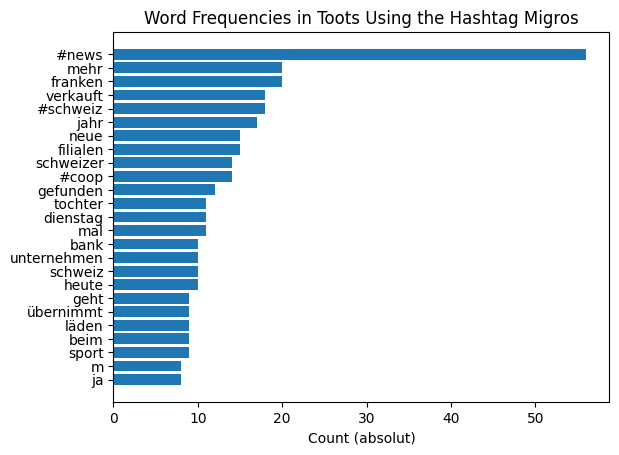

In [64]:
fig, ax = plt.subplots()

ax.barh(most_common_25["words"], most_common_25["count"])

ax.set_xlabel('Count (absolut)')
ax.set_title('Word Frequencies in Toots Using the Hashtag Migros')
ax.invert_yaxis()

plt.show()

## Experiment: bigrams

In this small experiment, co-occurring words - or, for two co-occuring words so called bigrams - are explored. Bigrams (two-word sequences) is a helpful way to uncover relationships and themes within text data. (See below for more info)

To identify co-occurrence of two words in the toots, you can use bigrams from nltk. Begin with a list comprehension to create a list of all bigrams (i.e. co-occurring words) in the toots.

In [59]:
terms_bigram = [list(bigrams(tweet)) for tweet in toots_no_cw]

To get an idea of what the result looks like, print all the bigrams of the first toot. The words are paired by co-occurrence. To get an idea of the original toot, toots_no_urls[0] is printed out as well. Remember that toots_no_urls is not completely cleaned.

In [60]:
terms_bigram[0]

[('zürich', 'baut'),
 ('baut', 'deutscher'),
 ('deutscher', 'tochter'),
 ('tochter', 'tegut'),
 ('tegut', 'zürich'),
 ('zürich', 'setzt'),
 ('setzt', 'verlustreichen'),
 ('verlustreichen', 'deutschen'),
 ('deutschen', 'tochter'),
 ('tochter', 'tegut'),
 ('tegut', 'sparhammer'),
 ('sparhammer', 'verkauft'),
 ('verkauft', 'zehnte'),
 ('zehnte', 'filiale'),
 ('filiale', 'streicht'),
 ('streicht', '120'),
 ('120', 'vollzeitstellen'),
 ('vollzeitstellen', 'besetzt'),
 ('besetzt', 'geschäftsleitung'),
 ('geschäftsleitung', 'neu'),
 ('neu', '#genossenschaftmigroszürich'),
 ('#genossenschaftmigroszürich', '#news')]

In [61]:
toots_no_urls[0]

'Migros Zürich baut bei deutscher Tochter Tegut umDie Migros Zürich setzt bei ihrer verlustreichen deutschen Tochter Tegut den Sparhammer an. Sie verkauft jede zehnte Filiale, streicht 120 Vollzeitstellen und besetzt die Geschäftsleitung neu.   #Migros #GenossenschaftMigrosZürich #news'

Now, the frequency of each bigram can be calculated. First, the list of lists - which is a list of each toot but stored are the bigrams of each toot (see above) - has to be flatened using itertools. After that the frequency of each bigram is calculated and the most common 25 are printed out.

In [62]:
bigrams = list(itertools.chain(*terms_bigram))

In [63]:
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(25)

[(('milliarden', 'franken'), 6),
 (('sport', 'x'), 6),
 (('#migrosbank', '#news'), 5),
 (('bike', 'world'), 5),
 (('vergangenen', 'jahr'), 5),
 (('millionen', 'franken'), 5),
 (('genossenschafts', 'bund'), 5),
 (('filialen', 'eröffnen'), 4),
 (('"orange', 'riese'), 4),
 (('12', '14'), 4),
 (('mitteilung', 'dienstag'), 4),
 (('bund', '(mgb'), 4),
 (('immobiliengruppe', 'signa'), 4),
 (('signa', 'schuldet'), 4),
 (('schuldet', 'laut'), 4),
 (('verkleinerung', 'verwaltung'), 4),
 (('m', 'budget'), 4),
 (('tochter', 'tegut'), 3),
 (('neue', 'filialen'), 3),
 (('velohändler', 'thömus'), 3),
 (('filialen', 'käufer'), 3),
 (('käufer', 'gefunden'), 3),
 (('ochsner', 'sport'), 3),
 (('x', 'filialen'), 3),
 (('#denner', '#news'), 3)]

It is still not super interesting. Most frequent is the 3migros - 3news combination which comes from the account that posts about business, entrepreneurship in Switzerland. Then we have the #migros plus #coop pair which leads to toots about the biggest two retailers in Switzerland. One can find some of the other companies belonging to the cooperative, like BikeWorld or Sport X or MigrosBank. There are also some bigrams pointing to business numbers (milliarden franken, millionen franken) or business activities (neue filialen, filialen eroeffnen).

**Why bigrams can be a good tool**

Identify Key Topics and Themes: By visualizing frequent bigram connections, you can see which words often appear together, giving insights into common phrases, prevalent topics, or central themes within the data.

Understand Contextual Relationships: Bigrams reveal context by showing how certain words are linked in sentences. This can help in understanding the context or sentiment associated with particular terms.

Discover Patterns or Trends: Over time, certain bigram patterns might emerge. For example, phrases related to specific periods or recurring themes can point to shifts in public opinion, product trends, or sentiment changes.

Text Summarization: Network diagrams of bigrams can summarize large text datasets by showing the most connected nodes. For instance, if you’re analyzing customer feedback, bigram networks can spotlight common customer concerns or preferences.

Aid in Topic Modeling: Bigram networks can support topic modeling by providing a foundation of common word pairs that signal different topics, which you can further analyze with more advanced techniques like clustering or topic modeling algorithms.

Exploratory Data Analysis (EDA): Before running deeper text analysis, a bigram network visualization is a great EDA tool for spotting interesting terms and relationships that may warrant further analysis.